In [69]:
import pandas as pd

In [70]:
data_cleaned = pd.read_csv('data_cleaned.csv')

In [71]:
data_cleaned['Sentiment'] = data_cleaned['Sentiment'].replace({'religion':0,'age':1,'ethnicity':2,'gender':3,'not_cyberbullying':4})

In [72]:
from sklearn.model_selection import train_test_split

X = data_cleaned['TweetText_clean']
y = data_cleaned['Sentiment']

# Split the data first
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [73]:
print("X train shape: ",X_train.shape)
print("y train shape: ",y_train.shape)

X train shape:  (28528,)
y train shape:  (28528,)


In [74]:
import numpy as np

(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 6306],
       [   1, 6294],
       [   2, 5942],
       [   3, 5748],
       [   4, 4238]], dtype=int64)

In [75]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences of integers
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val = tokenizer.texts_to_sequences(X_val)

max_len = 97
# max_len = 97
X_train = pad_sequences(X_train, maxlen=max_len, padding='pre', truncating='pre')
X_test = pad_sequences(X_test, maxlen=max_len, padding='pre', truncating='pre')
X_val = pad_sequences(X_val, maxlen=max_len, padding='pre', truncating='pre')

In [76]:
print("X train shape: ",X_train.shape)
print("y train shape: ",y_train.shape)

X train shape:  (28528, 97)
y train shape:  (28528,)


In [77]:
X_train

array([[   0,    0,    0, ...,    1, 6637, 6638],
       [   0,    0,    0, ...,  975,   15,  292],
       [   0,    0,    0, ...,  282,   96,  124],
       ...,
       [   0,    0,    0, ...,    9,    6,  472],
       [   0,    0,    0, ...,   20, 1168,  165],
       [   0,    0,    0, ...,   12, 2314,  536]])

In [78]:
y_train

23675    1
9041     3
12963    0
7406     3
11405    3
        ..
17042    0
5472     3
34050    2
336      4
27546    1
Name: Sentiment, Length: 28528, dtype: int64

In [79]:
# Undersampling
from imblearn.under_sampling import RandomUnderSampler

# Apply RUS to the training data
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

In [80]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[   0, 4238],
       [   1, 4238],
       [   2, 4238],
       [   3, 4238],
       [   4, 4238]], dtype=int64)

In [81]:
print("X train shape: ",X_train.shape)
print("y train shape: ",y_train.shape)

X train shape:  (21190, 97)
y train shape:  (21190,)


In [82]:
X_train

array([[   0,    0,    0, ...,   90,  313,  344],
       [   0,    0,    0, ..., 1452,  421,  861],
       [   0,    0,    0, ...,  343,  362,  356],
       ...,
       [   0,    0,    0, ..., 1180,  185, 1125],
       [   0,    0,    0, ..., 1592,  521, 6657],
       [   0,    0,    0, ...,   20, 1168,  165]])

In [83]:
y_train

0        0
1        0
2        0
3        0
4        0
        ..
21185    4
21186    4
21187    4
21188    4
21189    4
Name: Sentiment, Length: 21190, dtype: int64

# **3 Hidden Layers**

In [29]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense

bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=97))
bilstm_model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(8, return_sequences=False, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(32, activation='relu')) 
bilstm_model.add(Dense(5, activation='softmax'))

In [30]:
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [32]:
history = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 133s 353ms/step - accuracy: 0.4617 - loss: 1.5550 - val_accuracy: 0.8683 - val_loss: 0.5580
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 111s 335ms/step - accuracy: 0.8068 - loss: 0.6765 - val_accuracy: 0.8871 - val_loss: 0.4653
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 105s 315ms/step - accuracy: 0.8434 - loss: 0.5305 - val_accuracy: 0.8781 - val_loss: 0.4753
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 102s 307ms/step - accuracy: 0.8815 - loss: 0.4499 - val_accuracy: 0.9126 - val_loss: 0.3659
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 98s 294ms/step - accuracy: 0.9108 - loss: 0.3455 - val_accuracy: 0.9061 - val_loss: 0.3918
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 99s 299ms/step - accuracy: 0.9232 - loss: 0.3150 - val_accuracy: 0.9061 - val_loss: 0.3829
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 97s 292ms/step - accuracy: 0.9396 - loss: 0.2643 - val_accuracy: 0.9011 - val_loss: 0.4455


In [33]:
bilstm_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 97, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 97, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 97, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 97, 64)         │        73,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 97, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_10                │ (None, 16)             │         4,672 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,867,601 (18.57 MB)

 Trainable params: 1,622,533 (6.19 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,245,068 (12.38 MB)

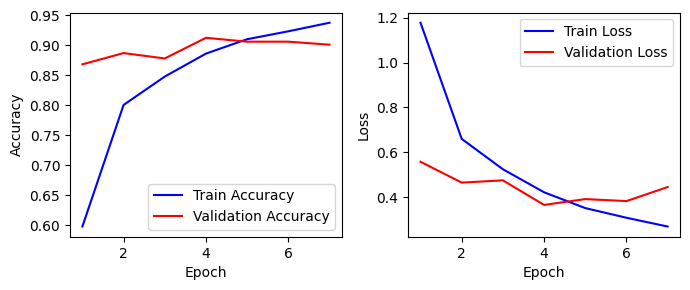

In [34]:
import matplotlib.pyplot as plt
acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1) #acc can be loss/accuracy

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2, 'b', label='Train Accuracy') # b = blue
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy') # r = red
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [35]:
#Evaluate the model
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred_bilstm = bilstm_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_bilstm = np.argmax(y_pred_bilstm, axis=1) 

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_bilstm)
print(f'Accuracy: {accuracy:.2f}')

# Display the classification report
print(classification_report(y_test, y_pred_bilstm))

112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step
Accuracy: 0.92
              precision    recall  f1-score   support

           0       0.97      0.92      0.94       789
           1       0.98      0.97      0.97       787
           2       0.96      0.98      0.97       744
           3       0.96      0.84      0.89       719
           4       0.71      0.90      0.80       531

    accuracy                           0.92      3570
   macro avg       0.92      0.92      0.92      3570
weighted avg       0.93      0.92      0.92      3570



In [36]:
test_loss, test_accuracy = bilstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.9208 - loss: 0.3481
Test Loss: 0.3511
Test Accuracy: 0.9213


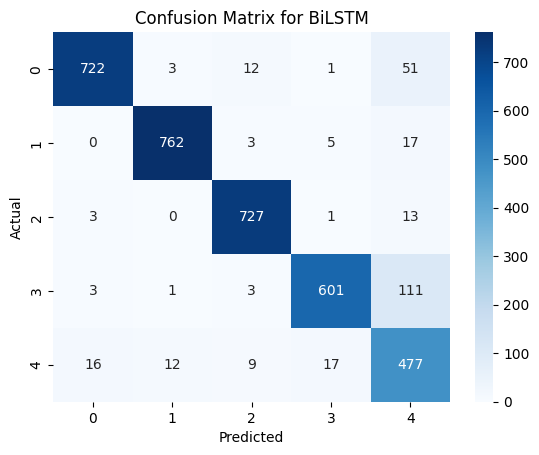

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BiLSTM')
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step


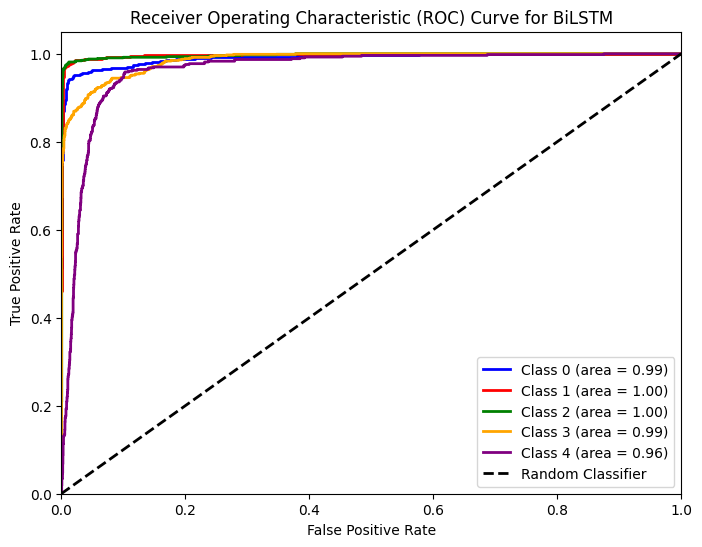

In [38]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the true labels 
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4]) 
n_classes = y_test_binarized.shape[1]

# Get the predicted probabilities for each class
y_score = bilstm_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple']) 

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot ROC curve for random classifier (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for BiLSTM')
plt.legend(loc="lower right")
plt.show()

# **5 hidden layers**

In [17]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dropout, Dense

bilstm_model = Sequential()
bilstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=97))
bilstm_model.add(Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(32, return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(16, return_sequences=True, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Bidirectional(LSTM(8, return_sequences=False, kernel_regularizer=l2(0.001))))
bilstm_model.add(Dropout(0.5))
bilstm_model.add(Dense(32, activation='relu')) 
bilstm_model.add(Dense(5, activation='softmax'))

c:\Users\hp\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [18]:
bilstm_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [19]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)

In [20]:
history = bilstm_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 188s 502ms/step - accuracy: 0.3358 - loss: 1.8371 - val_accuracy: 0.6285 - val_loss: 0.9130
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 150s 453ms/step - accuracy: 0.6056 - loss: 0.9630 - val_accuracy: 0.6954 - val_loss: 0.6970
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 143s 431ms/step - accuracy: 0.7108 - loss: 0.6958 - val_accuracy: 0.6848 - val_loss: 0.7287
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 144s 433ms/step - accuracy: 0.7083 - loss: 0.7369 - val_accuracy: 0.6985 - val_loss: 0.7100
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 144s 433ms/step - accuracy: 0.8197 - loss: 0.5574 - val_accuracy: 0.9053 - val_loss: 0.4589
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 2898s 9s/step - accuracy: 0.9317 - loss: 0.3542 - val_accuracy: 0.9050 - val_loss: 0.4231
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 187s 561ms/step - accuracy: 0.9500 - loss: 0.2839 - val_accuracy: 0.9075 - val_loss: 0.4168
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 164s 493ms/step - accuracy: 0.9579 - l

In [21]:
bilstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 97, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 97, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 97, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 97, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 97, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 97, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 97, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 97, 32)         │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 97, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 16)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,287,313 (20.17 MB)

 Trainable params: 1,762,437 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,524,876 (13.45 MB)

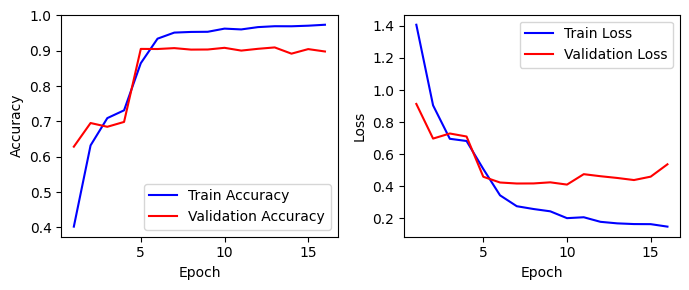

In [22]:
import matplotlib.pyplot as plt
acc2 = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss2 = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc2)+1) #acc can be loss/accuracy

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc2, 'b', label='Train Accuracy') # b = blue
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy') # r = red
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss2, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [23]:
#Evaluate the model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred_lstm = bilstm_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_lstm = np.argmax(y_pred_lstm, axis=1)  # Returns the index of the highest probability

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_lstm)
print(f'Accuracy: {accuracy:.2f}')

# Display the classification report
print(classification_report(y_test, y_pred_lstm))

112/112 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step
Accuracy: 0.91
              precision    recall  f1-score   support

           0       0.95      0.90      0.92       789
           1       0.95      0.97      0.96       787
           2       0.97      0.97      0.97       744
           3       0.92      0.85      0.89       719
           4       0.70      0.81      0.75       531

    accuracy                           0.91      3570
   macro avg       0.90      0.90      0.90      3570
weighted avg       0.91      0.91      0.91      3570



In [24]:
test_loss, test_accuracy = bilstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - accuracy: 0.9029 - loss: 0.4916
Test Loss: 0.4645
Test Accuracy: 0.9064


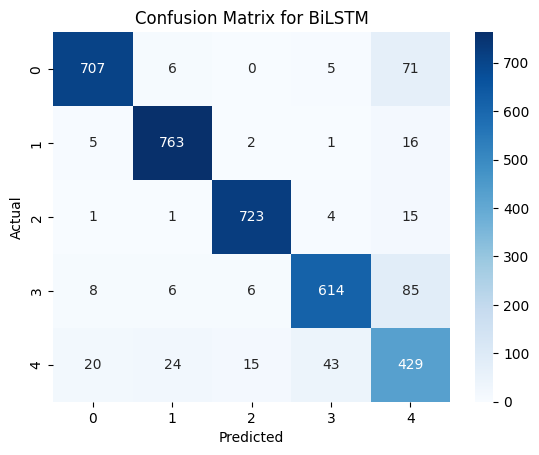

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BiLSTM')
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 50ms/step


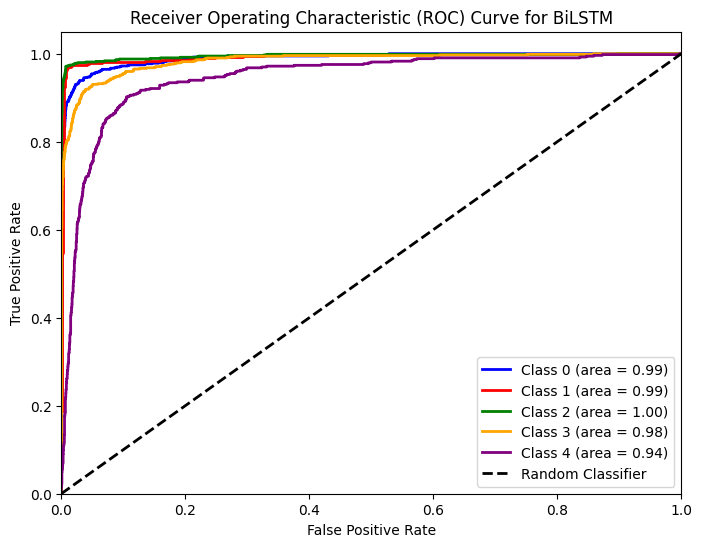

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the true labels (one-hot encode)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # Modify based on number of classes
n_classes = y_test_binarized.shape[1]

# Get the predicted probabilities for each class
y_score = bilstm_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])  # Add colors if more than 5 classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot ROC curve for random classifier (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for BiLSTM')
plt.legend(loc="lower right")
plt.show()

# **Tuning, 3 hidden layers**

In [55]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import kerastuner as kt

def build_bilstm_model(hp):
    units1 = hp.Int('units1', min_value=32, max_value=128, step=32)  # Dense units
    units2 = hp.Int('units2', min_value=16, max_value=64, step=16)  # Dense units
    units3 = hp.Int('units3', min_value=8, max_value=32, step=8)  # Dense units
    units4 = hp.Int('units4', min_value=16, max_value=64, step=16)  # Dense units
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh'])
    dropout1 = hp.Float('dropout1', min_value=0.4, max_value=0.8, step=0.1)
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh'])
    dropout2 = hp.Float('dropout2', min_value=0.4, max_value=0.8, step=0.1)
    activation_3 = hp.Choice('activation_3', values=['relu', 'tanh'])
    batch_size = hp.Choice('batch_size', values=[32, 64])
    dropout3 = hp.Float('dropout3', min_value=0.4, max_value=0.8, step=0.1)  # Dropout rate
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.00001,0.0001, 0.001])  # Learning rate
    l2_reg1 = hp.Choice('l2_reg1', values=[0.001, 0.01])  # L2 regularization
    l2_reg2 = hp.Choice('l2_reg2', values=[0.001, 0.01])  # L2 regularization
    l2_reg3 = hp.Choice('l2_reg3', values=[0.001, 0.01])  # L2 regularization

    bilstm_model = Sequential()
    bilstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=97))
    bilstm_model.add(Bidirectional(LSTM(units=units1, activation=activation_1, return_sequences=True, kernel_regularizer=l2(l2_reg1))))
    bilstm_model.add(Dropout(dropout1))
    bilstm_model.add(Bidirectional(LSTM(units=units2, activation=activation_2, return_sequences=True, kernel_regularizer=l2(l2_reg2))))
    bilstm_model.add(Dropout(dropout2))
    bilstm_model.add(Bidirectional(LSTM(units=units3, activation=activation_3, kernel_regularizer=l2(l2_reg3))))
    bilstm_model.add(Dropout(dropout3))
    bilstm_model.add(Dense(units=units4, activation='relu')) 
    bilstm_model.add(Dense(5, activation='softmax'))

    # Optimizer with gradient clipping
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    else:
        optimizer = SGD(learning_rate=learning_rate, clipnorm=1.0)

    bilstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return bilstm_model

In [49]:
tuner = kt.Hyperband(build_bilstm_model,
                    objective='val_accuracy', 
                    max_epochs=20,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_bilstm_3layers')

c:\Users\hp\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [50]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train, y_train, validation_data=(X_val, y_val),
                         callbacks=[early_stopping])

Trial 28 Complete [00h 29m 29s]
val_accuracy: 0.2356402426958084

Best val_accuracy So Far: 0.9094984531402588
Total elapsed time: 06h 04m 07s


In [60]:
# Get the best hyperparameter
best_bilstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best BiLSTM hyperparameters:', best_bilstm_hps.values)

Best BiLSTM hyperparameters: {'units1': 96, 'units2': 16, 'units3': 16, 'units4': 32, 'activation_1': 'tanh', 'dropout1': 0.4, 'activation_2': 'relu', 'dropout2': 0.5, 'activation_3': 'tanh', 'batch_size': 32, 'dropout3': 0.6000000000000001, 'optimizer': 'adam', 'learning_rate': 0.0001, 'l2_reg1': 0.001, 'l2_reg2': 0.01, 'l2_reg3': 0.01, 'tuner/epochs': 7, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0000'}


In [61]:
best_bilstm_model = tuner.hypermodel.build(best_bilstm_hps) 
history = best_bilstm_model.fit(X_train, y_train, epochs=50, batch_size=best_bilstm_hps.get('batch_size'),
                                validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50


c:\Users\hp\anaconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


664/664 ━━━━━━━━━━━━━━━━━━━━ 121s 164ms/step - accuracy: 0.2487 - loss: 3.9773 - val_accuracy: 0.5783 - val_loss: 2.1699
Epoch 2/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 108s 162ms/step - accuracy: 0.5234 - loss: 2.1226 - val_accuracy: 0.5001 - val_loss: 1.7093
Epoch 3/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 108s 163ms/step - accuracy: 0.4763 - loss: 1.7350 - val_accuracy: 0.5385 - val_loss: 1.2880
Epoch 4/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 107s 162ms/step - accuracy: 0.5457 - loss: 1.3510 - val_accuracy: 0.6178 - val_loss: 1.0946
Epoch 5/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 109s 164ms/step - accuracy: 0.5651 - loss: 1.2104 - val_accuracy: 0.5461 - val_loss: 1.2049
Epoch 6/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 109s 164ms/step - accuracy: 0.5813 - loss: 1.1417 - val_accuracy: 0.5864 - val_loss: 1.1101
Epoch 7/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 114s 172ms/step - accuracy: 0.5979 - loss: 1.0715 - val_accuracy: 0.6461 - val_loss: 0.9665
Epoch 8/50
664/664 ━━━━━━━━━━━━━━━━━━━━ 135s 204ms/step - accuracy: 0.6341 - loss: 0.93

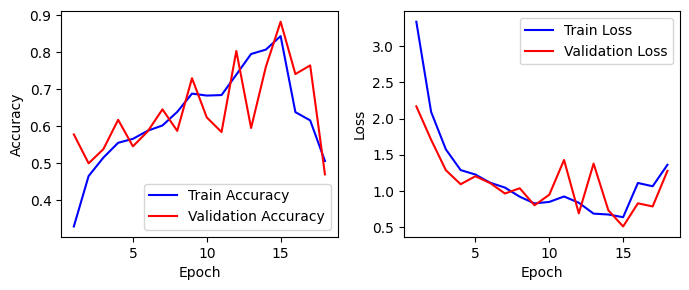

In [62]:
import matplotlib.pyplot as plt #testing
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc, 'b', label='Train Accuracy') # b = blue
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy') # r = red
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [63]:
#Evaluate the model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred_bilstm = best_bilstm_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_bilstm = np.argmax(y_pred_bilstm, axis=1)  # Returns the index of the highest probability

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_bilstm)
print(f'Accuracy: {accuracy:.2f}')

# Display the classification report
print(classification_report(y_test, y_pred_bilstm))

112/112 ━━━━━━━━━━━━━━━━━━━━ 8s 59ms/step
Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.95      0.88      0.91       789
           1       0.92      0.98      0.95       787
           2       0.95      0.92      0.94       744
           3       0.97      0.75      0.85       719
           4       0.60      0.83      0.70       531

    accuracy                           0.88      3570
   macro avg       0.88      0.87      0.87      3570
weighted avg       0.90      0.88      0.88      3570



In [64]:
best_bilstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ (None, 97, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_25                │ (None, 97, 192)        │       172,800 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 97, 192)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_26                │ (None, 97, 32)         │        26,752 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 97, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_27                │ (None, 32)             │         6,272 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,461,137 (17.02 MB)

 Trainable params: 1,487,045 (5.67 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,974,092 (11.35 MB)

In [66]:
test_loss, test_accuracy = best_bilstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.8743 - loss: 0.5401
Test Loss: 0.5305
Test Accuracy: 0.8762


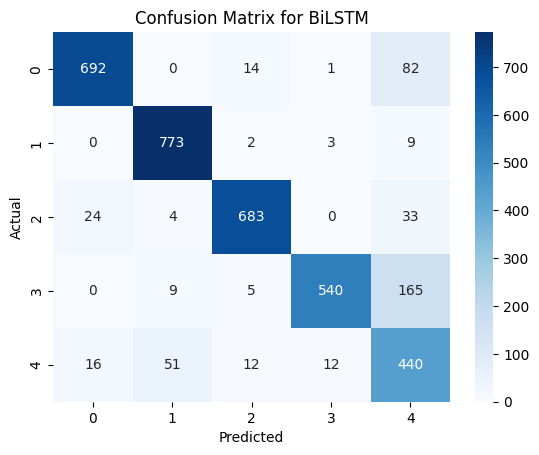

In [67]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BiLSTM')
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


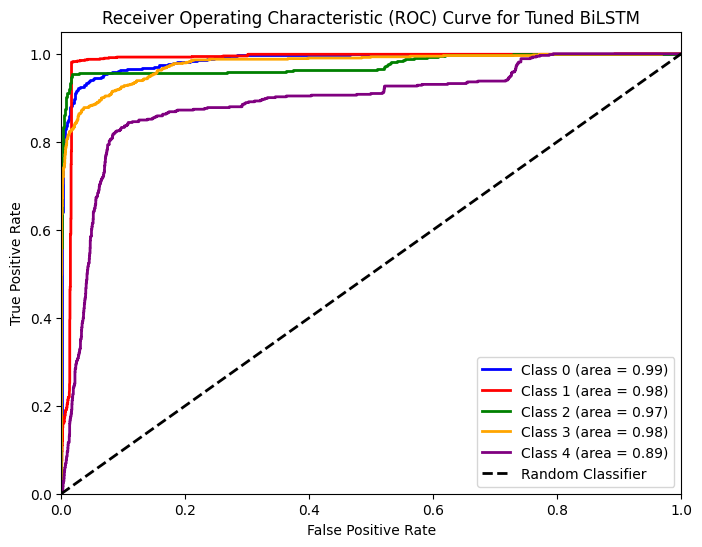

In [68]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the true labels (one-hot encode)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # Modify based on number of classes
n_classes = y_test_binarized.shape[1]

# Get the predicted probabilities for each class
y_score = best_bilstm_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])  # Add colors if more than 5 classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot ROC curve for random classifier (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Tuned BiLSTM')
plt.legend(loc="lower right")
plt.show()

# **Tuning, 5 hidden layers**

In [23]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
import kerastuner as kt

def build_bilstm_model(hp):
    units1 = hp.Int('units1', min_value=64, max_value=128, step=32)  # Dense units
    units2 = hp.Int('units2', min_value=32, max_value=64, step=16)  # Dense units
    units3 = hp.Int('units3', min_value=16, max_value=32, step=8)  # Dense units
    units4 = hp.Int('units4', min_value=8, max_value=16, step=8)  # Dense units
    units5 = hp.Int('units5', min_value=8, max_value=16, step=8)  # Dense units
    units6 = hp.Int('units6', min_value=16, max_value=32, step=8)  # Dense units
    activation_1 = hp.Choice('activation_1', values=['relu', 'tanh'])
    dropout1 = hp.Float('dropout1', min_value=0.3, max_value=0.8, step=0.1)
    activation_2 = hp.Choice('activation_2', values=['relu', 'tanh'])
    dropout2 = hp.Float('dropout2', min_value=0.3, max_value=0.8, step=0.1)
    activation_3 = hp.Choice('activation_3', values=['relu', 'tanh'])
    batch_size = hp.Choice('batch_size', values=[32, 64])
    dropout3 = hp.Float('dropout3', min_value=0.3, max_value=0.8, step=0.1)  # Dropout rate
    activation_4 = hp.Choice('activation_4', values=['relu', 'tanh'])
    activation_5 = hp.Choice('activation_5', values=['relu', 'tanh'])
    dropout4 = hp.Float('dropout4', min_value=0.3, max_value=0.8, step=0.1)  # Dropout rate
    dropout5 = hp.Float('dropout5', min_value=0.3, max_value=0.8, step=0.1)  # Dropout rate
    optimizer = hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd'])  # Optimizer
    learning_rate = hp.Choice('learning_rate', values=[0.00001,0.0001, 0.001])  # Learning rate
    l2_reg1 = hp.Choice('l2_reg1', values=[0.001, 0.01])  # L2 regularization
    l2_reg2 = hp.Choice('l2_reg2', values=[0.001, 0.01])  # L2 regularization
    l2_reg3 = hp.Choice('l2_reg3', values=[0.001, 0.01])  # L2 regularization
    l2_reg4 = hp.Choice('l2_reg4', values=[0.001, 0.01])  # L2 regularization
    l2_reg5 = hp.Choice('l2_reg5', values=[0.001, 0.01])  # L2 regularization

    bilstm_model = Sequential()
    bilstm_model.add(Embedding(input_dim=10000, output_dim=128, input_length=97))
    bilstm_model.add(Bidirectional(LSTM(units=units1, activation=activation_1, return_sequences=True, kernel_regularizer=l2(l2_reg1))))
    bilstm_model.add(Dropout(dropout1))
    bilstm_model.add(Bidirectional(LSTM(units=units2, activation=activation_2, return_sequences=True, kernel_regularizer=l2(l2_reg2))))
    bilstm_model.add(Dropout(dropout2))
    bilstm_model.add(Bidirectional(LSTM(units=units3, activation=activation_3, return_sequences=True, kernel_regularizer=l2(l2_reg3))))
    bilstm_model.add(Dropout(dropout3))
    bilstm_model.add(Bidirectional(LSTM(units=units4, activation=activation_4, return_sequences=True, kernel_regularizer=l2(l2_reg4))))
    bilstm_model.add(Dropout(dropout4))
    bilstm_model.add(Bidirectional(LSTM(units=units5, activation=activation_5, kernel_regularizer=l2(l2_reg5))))
    bilstm_model.add(Dropout(dropout5))
    bilstm_model.add(Dense(units=units6, activation='relu')) 
    bilstm_model.add(Dense(5, activation='softmax'))

    # Optimizer with gradient clipping
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)
    elif optimizer == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate, clipnorm=1.0)
    else:
        optimizer = SGD(learning_rate=learning_rate, clipnorm=1.0)

    bilstm_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return bilstm_model

In [24]:
tuner = kt.Hyperband(build_bilstm_model,
                    objective='val_accuracy', 
                    max_epochs=20,
                    factor=3,
                    directory='my_dir',
                    project_name='hyperband_bilstm_5layers')

Reloading Tuner from my_dir\hyperband_bilstm_5layers\tuner0.json


In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
hyperband = tuner.search(X_train, y_train, validation_data=(X_val, y_val),
                         callbacks=[early_stopping])

Trial 30 Complete [00h 30m 15s]
val_accuracy: 0.2810311019420624

Best val_accuracy So Far: 0.9229475855827332
Total elapsed time: 13h 10m 10s


In [27]:
# Get the best hyperparameter
best_bilstm_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print('Best BiLSTM hyperparameters:', best_bilstm_hps.values)

Best BiLSTM hyperparameters: {'units1': 128, 'units2': 64, 'units3': 32, 'units4': 16, 'units5': 8, 'units6': 32, 'activation_1': 'tanh', 'dropout1': 0.6000000000000001, 'activation_2': 'tanh', 'dropout2': 0.7, 'activation_3': 'tanh', 'batch_size': 64, 'dropout3': 0.6000000000000001, 'activation_4': 'tanh', 'activation_5': 'tanh', 'dropout4': 0.7, 'dropout5': 0.3, 'optimizer': 'rmsprop', 'learning_rate': 0.0001, 'l2_reg1': 0.001, 'l2_reg2': 0.001, 'l2_reg3': 0.001, 'l2_reg4': 0.001, 'l2_reg5': 0.01, 'tuner/epochs': 20, 'tuner/initial_epoch': 7, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0014'}


In [28]:
best_bilstm_model = tuner.hypermodel.build(best_bilstm_hps)

history = best_bilstm_model.fit(X_train, y_train, epochs=50, batch_size=best_bilstm_hps.get('batch_size'),
                                validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 376s 1s/step - accuracy: 0.2290 - loss: 3.3925 - val_accuracy: 0.2754 - val_loss: 2.9436
Epoch 2/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 272s 819ms/step - accuracy: 0.3333 - loss: 2.7743 - val_accuracy: 0.4228 - val_loss: 2.2532
Epoch 3/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 242s 729ms/step - accuracy: 0.3748 - loss: 2.1889 - val_accuracy: 0.4262 - val_loss: 1.8300
Epoch 4/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 248s 749ms/step - accuracy: 0.3896 - loss: 1.8064 - val_accuracy: 0.4304 - val_loss: 1.5704
Epoch 5/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 257s 775ms/step - accuracy: 0.3974 - loss: 1.5627 - val_accuracy: 0.4430 - val_loss: 1.3848
Epoch 6/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 257s 773ms/step - accuracy: 0.4718 - loss: 1.3647 - val_accuracy: 0.5467 - val_loss: 1.1624
Epoch 7/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 257s 774ms/step - accuracy: 0.5808 - loss: 1.1382 - val_accuracy: 0.6750 - val_loss: 0.9890
Epoch 8/50
332/332 ━━━━━━━━━━━━━━━━━━━━ 256s 773ms/step - accuracy: 0.6757 - lo

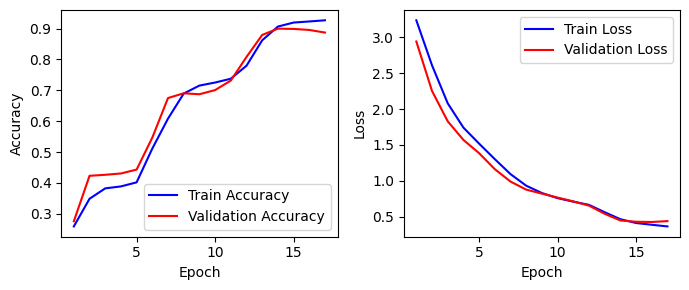

In [29]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

# Creating subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(7,3))

axes[0].plot(epochs, acc, 'b', label='Train Accuracy') # b = blue
axes[0].plot(epochs, val_acc, 'r', label='Validation Accuracy') # r = red
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label='Train Loss')
axes[1].plot(epochs, val_loss, 'r', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjusting layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

In [30]:
best_bilstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 97, 128)        │     1,280,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 97, 256)        │       263,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 97, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 97, 128)        │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 97, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 97, 64)         │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 97, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_8 (Bidirectional) │ (None, 97, 32)         │        10,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 97, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_9 (Bidirectional) │ (None, 16)             │         2,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,524,876 (13.45 MB)

 Trainable params: 1,762,437 (6.72 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,762,439 (6.72 MB)

In [31]:
#Evaluate the model

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Predict on the test set
y_pred_bilstm = best_bilstm_model.predict(X_test)

# Convert predicted probabilities to class labels
y_pred_bilstm = np.argmax(y_pred_bilstm, axis=1)  # Returns the index of the highest probability

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred_bilstm)
print(f'Accuracy: {accuracy:.2f}')

# Display the classification report
print(classification_report(y_test, y_pred_bilstm))

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 126ms/step
Accuracy: 0.90
              precision    recall  f1-score   support

           0       0.95      0.87      0.91       789
           1       0.97      0.96      0.97       787
           2       0.96      0.96      0.96       744
           3       0.90      0.86      0.88       719
           4       0.71      0.83      0.76       531

    accuracy                           0.90      3570
   macro avg       0.90      0.90      0.90      3570
weighted avg       0.91      0.90      0.90      3570



In [32]:
test_loss, test_accuracy = best_bilstm_model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.9005 - loss: 0.4173
Test Loss: 0.4291
Test Accuracy: 0.9022


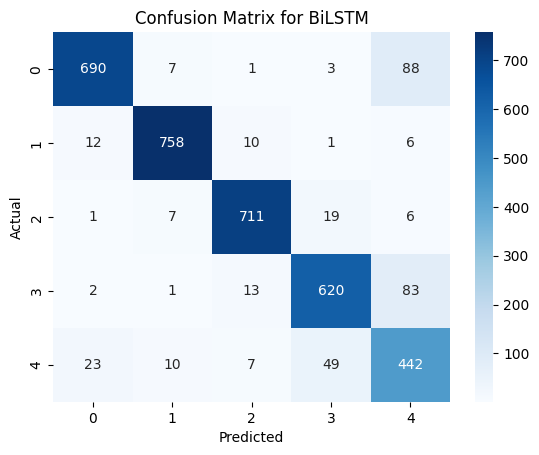

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion matrix heatmap
sns.heatmap(confusion_matrix(y_test, y_pred_bilstm), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for BiLSTM')
plt.show()

112/112 ━━━━━━━━━━━━━━━━━━━━ 19s 171ms/step


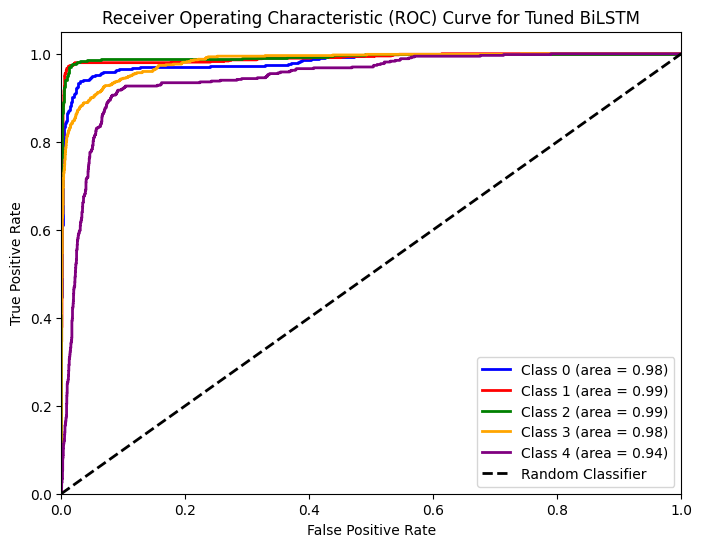

In [34]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from itertools import cycle

# Binarize the true labels (one-hot encode)
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3, 4])  # Modify based on number of classes
n_classes = y_test_binarized.shape[1]

# Get the predicted probabilities for each class
y_score = best_bilstm_model.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])  # Add colors if more than 5 classes

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {i} (area = {roc_auc[i]:.2f})')

# Plot ROC curve for random classifier (diagonal)
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Tuned BiLSTM')
plt.legend(loc="lower right")
plt.show()